# Introduction
Here i started first by installing the EMD method. I have followed the tutorial from https://emd.readthedocs.io/en/stable/emd_tutorials/index.html where multiple jupyter notebooks were available to understand the different methods and components involved in the EMD method. 

All the code below is taken from the tutorial where i have tried to understand and try to simulate different signals to see how the outcome changed accordingly.

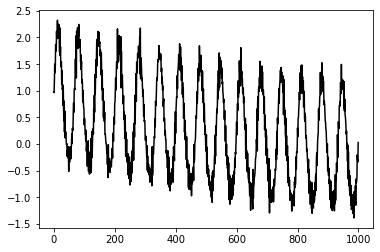

In [2]:
import emd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


sample_rate = 1000
seconds = 1
num_samples = sample_rate*seconds
time_vect = np.linspace(0, seconds, num_samples)
freq = 15

# Change extent of deformation from sinusoidal shape [-1 to 1]
nonlinearity_deg = .25

# Change left-right skew of deformation [-pi to pi]
nonlinearity_phi = -np.pi/4

# Create a non-linear oscillation
x = emd.simulate.abreu2010(freq, nonlinearity_deg, nonlinearity_phi, sample_rate, seconds)

x -= np.sin(2 * np.pi * 0.22 * time_vect)   # Add part of a very slow cycle as a trend

# Add a little noise - with low frequencies removed to make this example a
# little cleaner...
np.random.seed(42)
n = np.random.randn(1000,) * .2
nf = signal.savgol_filter(n, 3, 1)
n = n - nf

x = x + n

plt.figure()
plt.plot(x, 'k')

# sphinx_gallery_thumbnail_number = 8

In the tutorial there was a whole process explained regarding finding the avg envolope of the signal and the signal removing without them. We also found the numerous iterations by hand so the function ``my_get_next_imf`` was defined which will repeat the steps above until the average envelopes are sufficiently close to zero as defined by the ``sd_thresh``

In [4]:
def my_get_next_imf(x, zoom=None, sd_thresh=0.1):

    proto_imf = x.copy()  # Take a copy of the input so we don't overwrite anything
    continue_sift = True  # Define a flag indicating whether we should continue sifting
    niters = 0            # An iteration counter

    if zoom is None:
        zoom = (0, x.shape[0])

    # Main loop - we don't know how many iterations we'll need so we use a ``while`` loop
    while continue_sift:
        niters += 1  # Increment the counter

        # Compute upper and lower envelopes
        upper_env = emd.sift.interp_envelope(proto_imf, mode='upper')
        lower_env = emd.sift.interp_envelope(proto_imf, mode='lower')

        # Compute average envelope
        avg_env = (upper_env+lower_env) / 2

        # Add a summary subplot
        plt.subplot(5, 1, niters)
        plt.plot(proto_imf[zoom[0]:zoom[1]], 'k')
        plt.plot(upper_env[zoom[0]:zoom[1]])
        plt.plot(lower_env[zoom[0]:zoom[1]])
        plt.plot(avg_env[zoom[0]:zoom[1]])

        # Should we stop sifting?
        stop, val = emd.sift.sd_stop(proto_imf-avg_env, proto_imf, sd=sd_thresh)

        # Remove envelope from proto IMF
        proto_imf = proto_imf - avg_env

        # and finally, stop if we're stopping
        if stop:
            continue_sift = False

    # Return extracted IMF
    return proto_imf

The core parts of this function should be familiar from earlier parts of the
tutorial. We can now call this function to find the fastest IMF from our
signal.

Let's extract our IMF, plotting the iterations and zooming in to a 100 sample
period so we can see the details.


Here we plot the original signal, the first IMF and the residual after subtracting the first IMF from the signal.


([], <a list of 0 Text major ticklabel objects>)

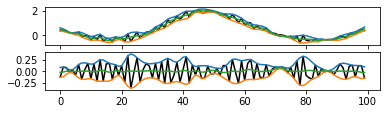

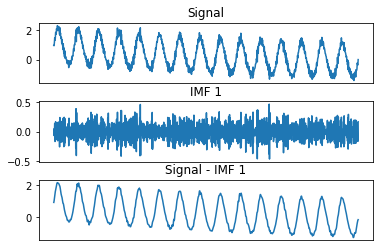

In [9]:
imf1 = my_get_next_imf(x, zoom=(100, 200))

print('Here we plot the original signal, the first IMF and the residual after subtracting the first IMF from the signal.')

plt.figure()
plt.subplots_adjust(hspace=0.3)

plt.subplot(311)
plt.plot(x)
plt.title('Signal')
plt.xticks([])

plt.subplot(312)
plt.plot(imf1)
plt.title('IMF 1')
plt.xticks([])

plt.subplot(313)
plt.plot(x - imf1)
plt.title('Signal - IMF 1')
plt.xticks([])

We can repeat the process on this residual to identify our next IMF. The
process of peak detection, envelope interpolation and subtraction is
identical for this second IMF. Critically, as we've removed the first IMF -
the peaks will be further apart in this iteration and we will extract slower
dynamics. Therefore we zoom into a slightly longer 200 sample window.

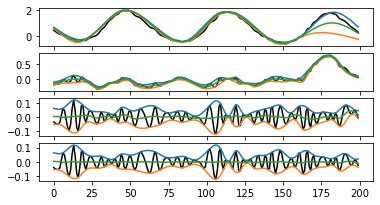

In [10]:
imf2 = my_get_next_imf(x - imf1, zoom=(100, 300))

This whole process is implemented in ``emd.sift.sift``. Here we run the sift
using the top level function and recover the same components as we generated
during this tutorial.


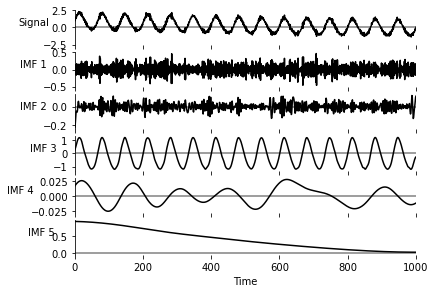

In [3]:
imf = emd.sift.sift(x, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf)